In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class StandardScaler:
    """Custom implementation of StandardScaler"""
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=1)
        self.scale_[self.scale_ == 0] = 1
        return self
        
    def transform(self, X):
        return (X - self.mean_) / self.scale_
        
    def fit_transform(self, X):
        return self.fit(X).transform(X)
        
    def inverse_transform(self, X):
        return X * self.scale_ + self.mean_

def train_test_split(X, y, test_size=0.2, random_state=None):
    """Custom implementation of train_test_split"""
    if random_state is not None:
        np.random.seed(random_state)
        
    n_samples = len(X)
    n_test = int(n_samples * test_size)
    
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    return (X[train_indices], X[test_indices], 
            y[train_indices], y[test_indices])

In [2]:
class RidgeRegression:
    """Ridge Regression implementation with mini-batch gradient descent"""
    
    def __init__(self, alpha=1.0, max_iter=3000, tol=1e-6, learning_rate=0.001,
                 batch_size=32, decay_rate=0.95, early_stopping_rounds=50):
        """
        Initialize Ridge Regression model.
        
        Parameters:
        -----------
        alpha : float, default=1.0
            Regularization strength (λ in the Ridge formula)
        max_iter : int, default=3000
            Maximum number of iterations for gradient descent
        tol : float, default=1e-6
            Tolerance for convergence
        learning_rate : float, default=0.001
            Initial learning rate for gradient descent
        batch_size : int, default=32
            Size of mini-batches for gradient descent
        decay_rate : float, default=0.95
            Learning rate decay factor
        early_stopping_rounds : int, default=50
            Number of iterations to wait before early stopping
        """
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.early_stopping_rounds = early_stopping_rounds
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.val_loss_history = []
        self.weights_path = []
        self.best_weights = None
        self.best_bias = None
        self.best_val_loss = float('inf')
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Fit Ridge regression model using mini-batch gradient descent.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target values
        X_val : array-like of shape (n_val_samples, n_features), optional
            Validation data
        y_val : array-like of shape (n_val_samples,), optional
            Validation target values
        """
        n_samples, n_features = X.shape
        
        if X_val is None or y_val is None:
            val_size = int(0.1 * n_samples)
            indices = np.random.permutation(n_samples)
            X_val = X[indices[:val_size]]
            y_val = y[indices[:val_size]]
            X = X[indices[val_size:]]
            y = y[indices[val_size:]]
            n_samples = len(X)

        if self.weights is None:
            self.weights = np.random.randn(n_features) * 0.01
        if self.bias is None:
            self.bias = 0.0
            
        X_mean = np.mean(X, axis=0)
        X_std = np.std(X, axis=0)
        X_normalized = (X - X_mean) / (X_std + 1e-10)
        X_val_normalized = (X_val - X_mean) / (X_std + 1e-10)
        
        self.loss_history = []
        self.val_loss_history = []
        self.weights_path = []
        current_lr = self.learning_rate
        no_improvement = 0
        
        for iteration in range(self.max_iter):
            self.weights_path.append(self.weights.copy())
            
            indices = np.random.permutation(n_samples)
            for start_idx in range(0, n_samples, self.batch_size):
                batch_idx = indices[start_idx:start_idx + self.batch_size]
                X_batch = X_normalized[batch_idx]
                y_batch = y[batch_idx]
                
                y_pred_batch = np.dot(X_batch, self.weights) + self.bias
                
                dw = ((-2/len(batch_idx)) * np.dot(X_batch.T, (y_batch - y_pred_batch)) + 
                     2 * self.alpha * self.weights)  
                db = (-2/len(batch_idx)) * np.sum(y_batch - y_pred_batch)
                
                self.weights -= current_lr * dw
                self.bias -= current_lr * db
            
            current_loss = self._compute_loss(X_normalized, y)
            self.loss_history.append(current_loss)
            
            val_loss = self._compute_loss(X_val_normalized, y_val)
            self.val_loss_history.append(val_loss)
            
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_weights = self.weights.copy()
                self.best_bias = self.bias
                no_improvement = 0
            else:
                no_improvement += 1
                
            if no_improvement >= 10:
                current_lr *= self.decay_rate
                no_improvement = 0
                
            if no_improvement >= self.early_stopping_rounds:
                print(f"Early stopping at iteration {iteration}")
                break
                
            if iteration > 0 and abs(self.loss_history[-1] - self.loss_history[-2]) < self.tol:
                break
        
        self.weights = self.best_weights
        self.bias = self.best_bias
        
        self.weights = self.weights / (X_std + 1e-10)
        self.bias = self.bias - np.sum(self.weights * X_mean)
        
        return self
    
    def predict(self, X):
        """Make predictions using the fitted model"""
        return np.dot(X, self.weights) + self.bias
    
    def _compute_loss(self, X, y):
        """Compute MSE loss with L2 regularization"""
        y_pred = np.dot(X, self.weights) + self.bias
        mse = np.mean((y - y_pred) ** 2)
        l2_penalty = self.alpha * np.sum(self.weights ** 2)  
        return mse + l2_penalty

In [3]:
def generate_dataset(n_samples=1000, n_features=20, noise_level=0.1):
    X = np.random.uniform(-2, 2, (n_samples, n_features))
    
    X_poly = np.column_stack([
        X,
        np.square(X[:, :2]),  
        np.exp(X[:, 2:4] / 2),  
        np.sin(X[:, 4:6])  
    ])
    
    X_poly[:, 0] = 0.7 * X_poly[:, 1] + 0.3 * np.random.randn(n_samples)
    X_poly[:, 2] = -0.5 * X_poly[:, 3] + 0.5 * np.random.randn(n_samples)
    
    n_nonzero = int(0.3 * X_poly.shape[1])
    true_weights = np.zeros(X_poly.shape[1])
    nonzero_idx = np.random.choice(X_poly.shape[1], n_nonzero, replace=False)
    true_weights[nonzero_idx] = np.random.uniform(-2, 2, size=n_nonzero)
    
    y = np.dot(X_poly, true_weights)
    y += noise_level * np.random.randn(n_samples)
    
    return X_poly, y, true_weights

def plot_training_progress(model, feature_names=None):
    """Plot training progress including loss history and weight paths"""
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(model.loss_history, label='Training Loss')
    plt.plot(model.val_loss_history, label='Validation Loss')
    plt.title('Loss History during Training')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    weights_path = np.array(model.weights_path)
    for i in range(weights_path.shape[1]):
        label = f'Feature {i}' if feature_names is None else feature_names[i]
        plt.plot(weights_path[:, i], label=label, alpha=0.7)
    plt.title('Weight Paths during Training')
    plt.xlabel('Iteration')
    plt.ylabel('Weight Value')
    if weights_path.shape[1] <= 10:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_true_vs_predicted(y_true, y_pred, y_scaler=None):
    """Plot true vs predicted values with regression line"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.scatter(y_true, y_pred, alpha=0.5)
    ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    ax1.set_title('Scaled True vs Predicted Values')
    ax1.set_xlabel('True Values (scaled)')
    ax1.set_ylabel('Predicted Values (scaled)')
    
    if y_scaler is not None:
        y_true_orig = y_scaler.inverse_transform(y_true.reshape(-1, 1)).ravel()
        y_pred_orig = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        ax2.scatter(y_true_orig, y_pred_orig, alpha=0.5)
        ax2.plot([y_true_orig.min(), y_true_orig.max()], 
                [y_true_orig.min(), y_true_orig.max()], 'r--', lw=2)
        ax2.set_title('Original Scale True vs Predicted Values')
        ax2.set_xlabel('True Values (original)')
        ax2.set_ylabel('Predicted Values (original)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Scaled data range - True: [{y_true.min():.2f}, {y_true.max():.2f}], "
          f"Predicted: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
    if y_scaler is not None:
        print(f"Original data range - True: [{y_true_orig.min():.2f}, {y_true_orig.max():.2f}], "
              f"Predicted: [{y_pred_orig.min():.2f}, {y_pred_orig.max():.2f}]")

def plot_weight_comparison(true_weights, estimated_weights):
    """Plot comparison between true and estimated weights"""
    plt.figure(figsize=(10, 6))
    
    x = np.arange(len(true_weights))
    width = 0.35
    
    plt.bar(x - width/2, true_weights, width, label='True Weights', alpha=0.7)
    plt.bar(x + width/2, estimated_weights, width, label='Estimated Weights', alpha=0.7)
    
    plt.title('True vs Estimated Weights Comparison')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


Model Performance:
-----------------
Train MSE: 0.0007
Test MSE: 0.0008

Generating visualizations...
--------------------------

Plot 1: Training Progress


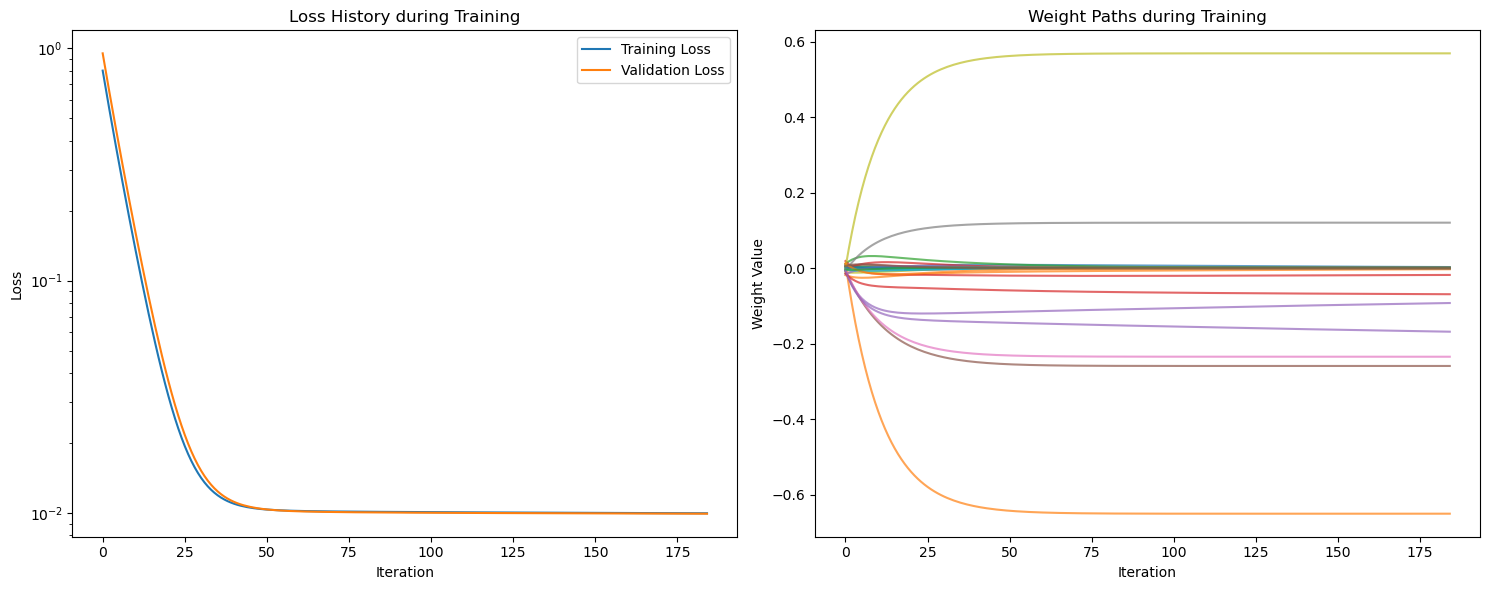


Plot 2: True vs Predicted Values


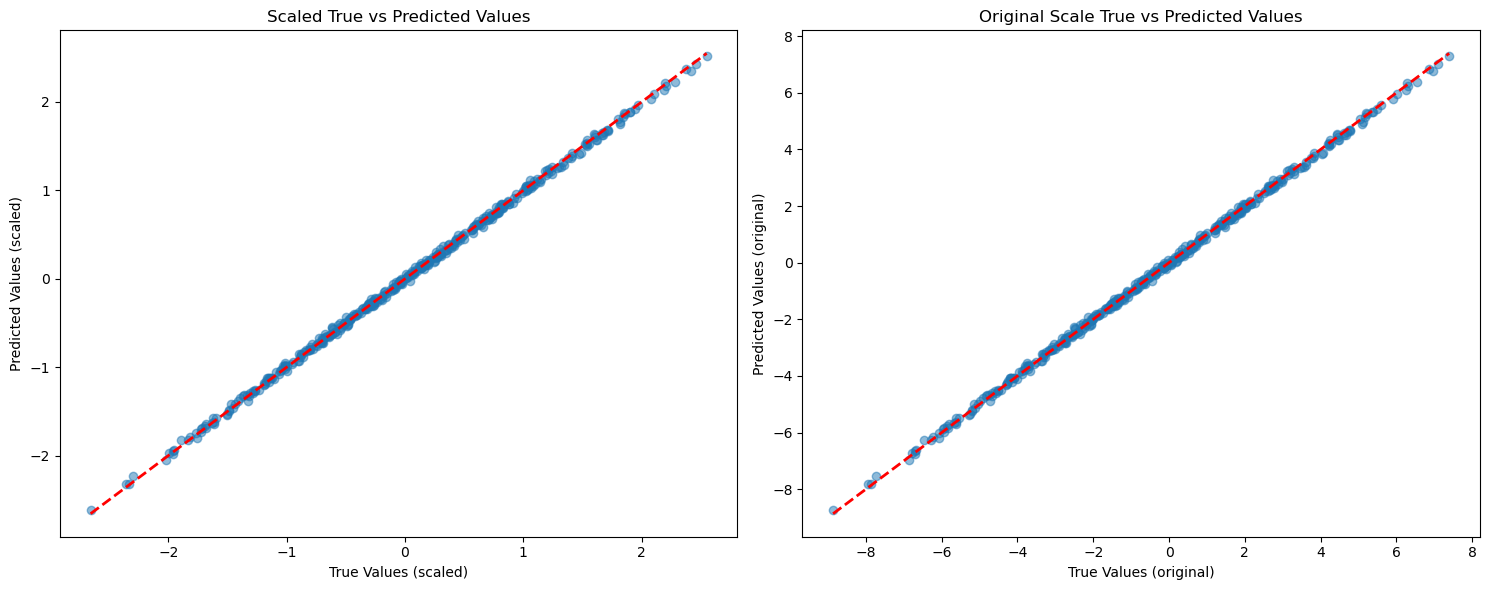

Scaled data range - True: [-2.66, 2.55], Predicted: [-2.62, 2.51]
Original data range - True: [-8.87, 7.39], Predicted: [-8.75, 7.28]

Plot 3: Weight Comparison


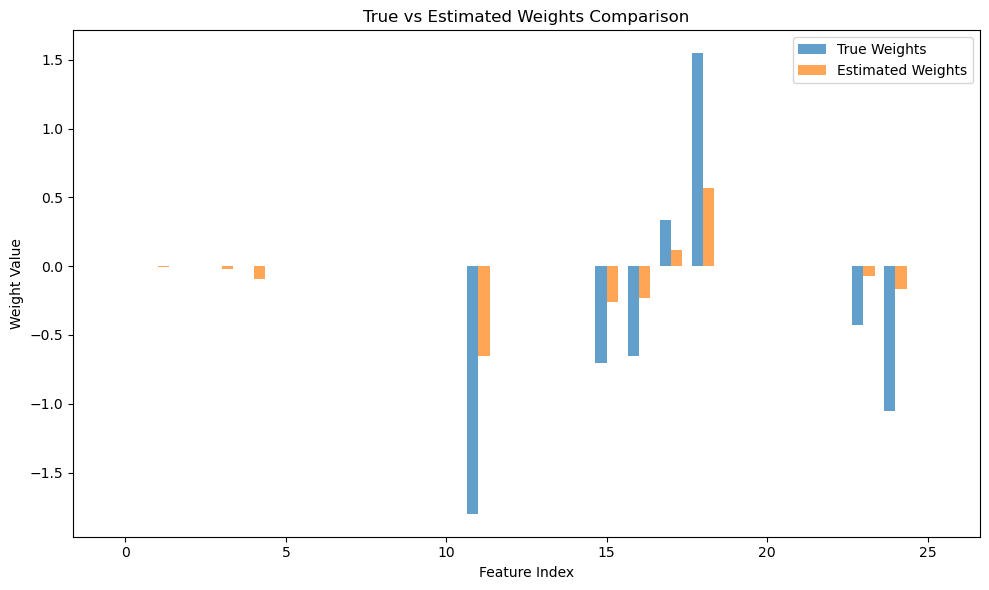


Model Analysis:
---------------
Number of features: 26
Number of non-zero weights: 26
Average absolute weight value: 0.0844
Maximum absolute weight value: 0.6519

Correlation between true and estimated weights: 0.9697
Final learning rate: 0.000397

Model converged after 185 iterations
Best validation loss: 0.0099


In [7]:
if __name__ == "__main__":
    X, y, true_weights = generate_dataset(
        n_samples=2000,
        n_features=20,
        noise_level=0.05
    )

    y_scaler = StandardScaler()
    y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RidgeRegression(
        alpha=0.01,          
        max_iter=3000,       
        learning_rate=0.001, 
        batch_size=32,       
        decay_rate=0.95,     
        early_stopping_rounds=50
    )

    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)
    
    print("\nModel Performance:")
    print("-----------------")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")

    print("\nGenerating visualizations...")
    print("--------------------------")
    
    print("\nPlot 1: Training Progress")
    plot_training_progress(model)
    
    print("\nPlot 2: True vs Predicted Values")
    plot_true_vs_predicted(y_test, y_test_pred, y_scaler)
    
    print("\nPlot 3: Weight Comparison")
    plot_weight_comparison(true_weights, model.weights)

    print("\nModel Analysis:")
    print("---------------")
    print(f"Number of features: {len(model.weights)}")
    print(f"Number of non-zero weights: {np.sum(np.abs(model.weights) > 1e-10)}")
    print(f"Average absolute weight value: {np.mean(np.abs(model.weights)):.4f}")
    print(f"Maximum absolute weight value: {np.max(np.abs(model.weights)):.4f}")
    
    weight_correlation = np.corrcoef(true_weights, model.weights)[0,1]
    print(f"\nCorrelation between true and estimated weights: {weight_correlation:.4f}")

    final_lr = model.learning_rate * (model.decay_rate ** (len(model.loss_history) // 10))
    print(f"Final learning rate: {final_lr:.6f}")
    
    if len(model.loss_history) < model.max_iter:
        print(f"\nModel converged after {len(model.loss_history)} iterations")
    else:
        print("\nModel reached maximum iterations without convergence")
        
    print(f"Best validation loss: {model.best_val_loss:.4f}")